# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from IPython.display import display, Image
%matplotlib inline

Below are some helper functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    

The following are additional functions written for the assignment.

In [4]:
def extend_end(x1, y1, x2, y2, length):
    """ Takes line endpoints and extends them by extrapolation to a given length"""
    line_len = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) 
    x = x2 + (x2 - x1) / line_len * length
    y = y2 + (y2 - y1) / line_len * length
    return x, y

def lane_filter(lines):
    """ 
    Takes an array of hough lines and separates them by slope.
    Negative slopes are associated with the left lane and 
    positive with the right.
    """
    right = []
    left = []
    for x1,y1,x2,y2 in lines[:, 0]:
        m = (float(y2) - y1) / (x2 - x1)
        if m >= 0: 
            right.append([x1,y1,x2,y2,m])
        else:
            left.append([x1,y1,x2,y2,m])
            
    #Filter the right and left lanes for lines with slope between two thresholds
    right = filter_slope(right,  thresh=(0.45, 0.75))
    right = merge_lines(right)
    
    left = filter_slope(left, thresh=(-0.85, -0.6))
    left = merge_lines(left)
    
    return right, left

def filter_slope(data, thresh, accept=0.08):
    """Filter the slopes to be between two thresholds and an acceptane level
    between the averages of the slopes
    """    
    data = np.array(data)
    data = data[(data[:, 4] >= thresh[0]) & (data[:, 4] <= thresh[1])]
    m = np.mean(data[:, 4], axis=0)
    return data[(data[:, 4] <= m+accept) & (data[:, 4] >= m-accept)]

def merge_lines(lines):
    """Merges all line segments by the mean of each endpoint, 
       and extends them off across the image"""
    
    lines = np.array(lines)[:, :4] #Don't need slope
    
    x1,y1,x2,y2 = np.mean(lines, axis=0)
    x1, y1 = extend_end(x1,y1,x2,y2, -1000) # bottom point
    x2, y2 = extend_end(x1,y1,x2,y2, 1000)  # top point
    line = np.array([[x1,y1,x2,y2]])
    
    return np.array([line], dtype=np.int32)

def average_with_prev(line, prev):
    """ Reduces vibrations and missed lines by averaging previous 
        frame line with current frame line. """
    if prev != None:
        line = np.concatenate((line[0], prev[0]))
        x1,y1,x2,y2 = np.mean(line, axis=0)
        line = np.array([[[x1,y1,x2,y2]]], dtype=np.int32)
        return line
    else: 
        return line
               

def hough_transform(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns Hough transform of image.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap) 
    
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    
    Having an α of for example 0.8 means that the image will be more transparent?
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def test_all_images():    
    #check if there is a tested folder, and delete it
    if not os.path.isfile('./test_images/tested'):
        import shutil
        shutil.rmtree('test_images/tested')
    
    file_list = ["test_images/" + s for s in os.listdir("test_images/")]
    
    #makes a tested folder.
    os.makedirs('test_images/tested')
    
    n = len(file_list)
    
    for i in range(n):
        print (file_list[i])
        plt.imshow(process_image(mpimg.imread(file_list[i])))
        plt.savefig('test_images/tested/processed_'+file_list[i][12:])
        
    return 'Tested all images, here is an example:'

def test_image():
    file_list = ["test_images/" + s for s in os.listdir("test_images/")]
    plt.imshow(process_image(mpimg.imread(file_list[0])))
    
     

## Test on Images


The image processing pipeline.

test_images/solidYellowCurve.jpg
test_images/solidWhiteCurve.jpg
test_images/solidYellowLeft.jpg
test_images/whiteCarLaneSwitch.jpg
test_images/solidWhiteRight.jpg


'Tested all images, here is an example:'

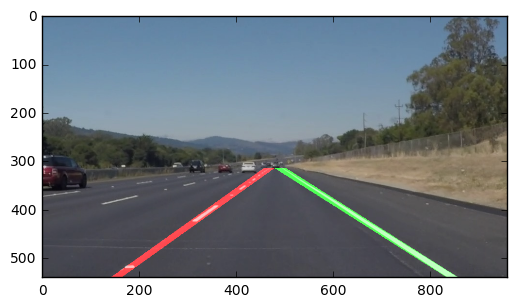

In [5]:
def process_image(image):
    """Image processing pipeline"""
    
    #Grey the image
    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing   
    blur_gray = gaussian_blur(gray, kernel_size = 7)

    # Define our parameters for Canny and apply
    edges = canny(gray, low_threshold = 50, high_threshold = 125)  
    
    #Define vertices for a mask on the image.
    imshape = image.shape
    bot_left = [75, imshape[0]]
    bot_right = [980, imshape[0]]
    top_right = [510, 315]
    top_left = [450, 315]
    vertices = [np.array([bot_left, bot_right, top_right, top_left], dtype=np.int32)]
    
    masked_image = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
  
    # Run hough on edge detected image
    hough_lines = hough_transform(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    #filter the hough_lines to find the right and left lane.
    right_lane, left_lane = lane_filter(hough_lines)
    
    
    ### Draw lines and return final image 
    line_img = np.copy((image)*0)
    draw_lines(line_img, right_lane, color = [0,255,0], thickness=12)
    draw_lines(line_img, left_lane, thickness=12)
    
    #Filter the line_img so lines are only in area of interest.
    line_img = region_of_interest(line_img, vertices)
    
    #Combine orignal image with line image
    result = weighted_img(line_img, image)
    
    return result


test_all_images()




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:31<00:00,  7.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 30.8 s, sys: 1.69 s, total: 32.5 s
Wall time: 34 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:36<00:00,  7.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 18s, sys: 3.74 s, total: 1min 22s
Wall time: 1min 38s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

The pipeline developed to detect lane lines in a camera feed on a car is as follows:

* __Gray scale__ - The image is set to gray scale. This makes it easier for the Canny Algorithm to detect all edge colors, not just the white ones.
* __Apply Gaussian blurring to the image__ - This helps to suppress noise in the image, so the Canny algorithm won't detect too many edges. The kernel size used was (5,5).
* __Mask Application__ - A mask is applied to the image, so the proceeding algorithms only act on the area of the image in which the lanes are expected to be contained.
* __Canny Edge Detection__ - This algorithms looks at the rate of change of pixels in the images and outputs it as an array. The areas that have a high rate of change (i.e the edge between two strongly different colors) will be highlighted. 
* __Hough Transform__ - This algorithm takes the Canny edge output and transforms it into line segments.
* __Filter Line Segments__ - The Hough Transform line segment coordinates are filtered by positive and negative slope then put into arrays for the right and left lane respectively.Further filtering is done to keep the line segments in a certain slope range. This is because the lane lines have a near fixed slope in the image frame, and lines detected with differing slopes are most likely not part of the lane.
* __Lane-Lines Generated__- Finally the lines segments are merged using the mean of the end-points and extended so that they span the whole lane-line. The advantage of this approach is that the lane can be represented as a single line and slope value. I envision when I am writing the machine learning algorithms to control this, having a two slopes that represent the lanes to input to the algorithm as a feature will be an advantage.
* __Mask Application__ - In order to give the final lines a sharp finish, and make sure they terminate before they cross, they are again masked.


### Shortcomings

As the masking region is a solid shape, the pipeline could be susceptible to edges in the middle of a lane. A speed marking, or perhaps a "SLOW DOWN" sign painted on the road could make the pipeline think that lane-line is in the middle of the lane. This could be disastrous in a real world environment. The solution could be another mask, that acts on the middle of the lane in addition to the mask that acts outside of the lane.

The pipeline does not work very well for the extra challenge. There is flickering caused by the edges detected in the shadow of the trees. This could be overcome using a color filter that acts before the edge detection to filter out the color of the shadow. In addition, a new area mask was defined. In a real SDC a way to dynamically program the area mask would need to be developed.



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [9]:
global right_prev
global left_prev
right_prev = None
left_prev = None



def process_extra_image(image):
    """Image processing pipeline"""
    global right_prev
    global left_prev
    
  
    #Grey the image
    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing   
    blur_gray = gaussian_blur(gray, kernel_size = 7)

    # Define our parameters for Canny and apply
    edges = canny(gray, low_threshold = 50, high_threshold = 125)  
    
    #Define new vertices for a mask on the image.
    bot_left = [250, 700]
    bot_right = [1100, 700]
    top_right = [725, 450]
    top_left = [580, 450]
    vertices = [np.array([bot_left, bot_right, top_right, top_left], dtype=np.int32)]
    
    masked_image = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
  
    # Run hough on edge detected image
    hough_lines = hough_transform(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    #filter the hough_lines to find the right and left lane.
    right_lane, left_lane = lane_filter(hough_lines)
    right_lane = average_with_prev(right_lane, right_prev)
    right_prev = right_lane
    
    left_lane = average_with_prev(left_lane, left_prev)
    left_prev = left_lane
    
    
    ### Draw lines and return final image 
    line_img = np.copy((image)*0)
    draw_lines(line_img, right_lane, color = [0,255,0], thickness=12)
    draw_lines(line_img, left_lane, thickness=12)
    
    #Filter the line_img so lines are only in area of interest.
    line_img = region_of_interest(line_img, vertices)
    
    #Combine orignal image with line image
    result = weighted_img(line_img, image)
    
    return result


In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_extra_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 37%|███▋      | 93/251 [00:19<00:44,  3.54it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))